In [0]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import urllib.request
from progressbar import *
import socket
import os
import shutil
import cv2
import dlib
from PIL import Image
from pathlib import Path
from skimage import io
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Dropout
from keras import models
from keras.models import Model
from keras import backend as K
from keras.layers import Input
from collections import defaultdict

# Reading data

[FaceScrub dataset link](http://vintage.winklerbros.net/facescrub.html "FaceScrub")   

<img align="left" width="580" height="200" src="http://vintage.winklerbros.net/Images/facescrub.jpg">   

In [0]:
base_dir = "/content/drive/My Drive/Colab/Roonyx/Face recognition"

f = open(base_dir + "/faceScrub/facescrub_actors.txt", 'r')
actors = []
for line in f:
    actor_info = line.split('\t')
    actors.append([actor_info[0], actor_info[3]])
actors = np.array(actors)
f.close()

f = open(base_dir + "/faceScrub/facescrub_actresses.txt", 'r')
actresses = []
for line in f:
    actresses_info = line.split('\t')
    actresses.append([actresses_info[0], actresses_info[3]])
actresses = np.array(actresses)
f.close()

## Example of data

In [0]:
pd.DataFrame(data=actors[1:11], columns=actors[0])

,name,url
0,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...
1,Aaron Eckhart,http://movies.dosthana.com/sites/default/files...
2,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...
3,Aaron Eckhart,http://25.media.tumblr.com/nJ2vga5sae9o2ks4Flt...
4,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...
5,Aaron Eckhart,http://media.zenfs.com/en_us/Movies/PhotoG/2nd...
6,Aaron Eckhart,http://img2.timeinc.net/people/i/2008/news/080...
7,Aaron Eckhart,http://latimesblogs.latimes.com/photos/uncateg...
8,Aaron Eckhart,http://collider.com/wp-content/uploads/Aaron-E...
9,Aaron Eckhart,http://movies.dosthana.com/sites/default/files...


## Dataset info

In [4]:
names_actors = unique_labels(actors[1:,0])
names_actresses = unique_labels(actresses[1:,0])

print("Num images: ", len(actors) + len(actresses) - 2)
print("Num images with actors: ", len(actors) - 1)
print("Num images with actresses: ", len(actresses) - 1)
print("Num actors:", len(names_actors))
print("Num actresses:", len(names_actresses))

Num images:  106863
Num images with actors:  55306
Num images with actresses:  51557
Num actors: 265
Num actresses: 265


## Download images

In [0]:
folder_for_actors = base_dir + "/faceScrub/actors_images"
# !mkdir '$folder_for_actors'
folder_for_actresses = base_dir + "/faceScrub/actresses_images"
# !mkdir '$folder_for_actresses'

In [0]:
def download(index_start, index_stop, sex='male'):

  def url_is_alive(url):
    try:
        urllib.request.urlopen(url)
        return True
    except Exception:
        return False

  if sex == "male":
    peoples = actors
  elif sex == "female":
    peoples = actresses
  else: 
    return None

  pbar = ProgressBar(maxval=index_stop-index_start)
  pbar.start()
  socket.setdefaulttimeout(5)

  # Download images
  progress = 0
  for image_id in range(index_start,index_stop,1):
    href = peoples[image_id,1]
    if(url_is_alive(href)):
      try:
        if sex == 'female':
          urllib.request.urlretrieve(href,folder_for_actresses+"/{}.jpg".format(image_id+len(actors)-1))
        else:  urllib.request.urlretrieve(href, folder_for_actors+"/{}.jpg".format(image_id))
      except Exception: pass
    pbar.update(progress)
    progress+=1
        
  pbar.finish()

In [0]:
download(1,10000,"male")

100% (9999 of 9999) |####################| Elapsed Time: 3:57:58 Time:  3:57:58


In [0]:
download(10000,20000,"male")

100% (10000 of 10000) |##################| Elapsed Time: 1:42:45 Time:  1:42:45


In [0]:
download(20000,30000,"male")

100% (10000 of 10000) |##################| Elapsed Time: 1:47:03 Time:  1:47:03


In [0]:
download(30000,40000,"male")

100% (10000 of 10000) |##################| Elapsed Time: 1:43:21 Time:  1:43:21


In [0]:
download(40000,55306,"male")

100% (15306 of 15306) |##################| Elapsed Time: 4:41:44 Time:  4:41:44


In [0]:
download(1,10000,"female")

100% (9999 of 9999) |####################| Elapsed Time: 2:13:33 Time:  2:13:33


In [0]:
download(10000,20000,"female")

100% (10000 of 10000) |##################| Elapsed Time: 1:58:13 Time:  1:58:13


In [0]:
download(20000,30000,"female")

100% (10000 of 10000) |##################| Elapsed Time: 1:38:27 Time:  1:38:27


In [0]:
download(30000,40000,"female")

100% (10000 of 10000) |##################| Elapsed Time: 3:57:18 Time:  3:57:18


In [0]:
download(40000,51557,"female")

100% (11557 of 11557) |##################| Elapsed Time: 2:22:22 Time:  2:22:22


In [0]:
print("Num downloaded images:", len(os.listdir(folder_for_actors))+len(os.listdir(folder_for_actresses)))

Num downloaded images: 57198


## Searching broken images

In [0]:
folder_for_bad_actors = base_dir + "/faceScrub/actors_bad_images"
# !mkdir '$folder_for_bad_actors'
folder_for_bad_actresses = base_dir + "/faceScrub/actresses_bad_images"
# !mkdir '$folder_for_bad_actresses'

In [0]:
actors_files_names = os.listdir(folder_for_actors)

pbar = ProgressBar(maxval=len(actors_files_names))
pbar.start()
progress = 0
for i in range(0,len(actors_files_names),1):
  index_dot = actors_files_names[i].find('.')
  actors_files_names[i] = int(actors_files_names[i][:index_dot])
  try:
    image = cv2.imread(folder_for_actors+"/{}.jpg".format(actors_files_names[i]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  except Exception:
      shutil.move(folder_for_actors+"/{}.jpg".format(actors_files_names[i]),
                  folder_for_bad_actors+"/{}.jpg".format(actors_files_names[i]))
  pbar.update(progress)
  progress+=1   
pbar.finish()

100% (29804 of 29804) |##################| Elapsed Time: 2:07:42 Time:  2:07:42


In [0]:
actresses_files_names = os.listdir(folder_for_actresses)

pbar = ProgressBar(maxval=len(actresses_files_names))
pbar.start()
progress = 0
for i in range(0,len(actresses_files_names),1):
  index_dot = actresses_files_names[i].find('.')
  actresses_files_names[i] = int(actresses_files_names[i][:index_dot])
  try:
    image = cv2.imread(folder_for_actresses+"/{}.jpg".format(actresses_files_names[i]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  except Exception:
      shutil.move(folder_for_actresses+"/{}.jpg".format(actresses_files_names[i]),
                  folder_for_bad_actresses+"/{}.jpg".format(actresses_files_names[i]))
  pbar.update(progress)
  progress+=1   
pbar.finish()

100% (27394 of 27394) |##################| Elapsed Time: 2:59:52 Time:  2:59:52


In [0]:
print("Num broken images: ", len(os.listdir(folder_for_bad_actors)) + len(os.listdir(folder_for_bad_actresses)))
print("Num good images: ", len(os.listdir(folder_for_actors)) + len(os.listdir(folder_for_actresses)))

Num broken images:  7486
Num good images:  49712


## Crope faces on images

In [0]:
folder_for_croped_images = base_dir + "/faceScrub/croped_images"
# !mkdir '$folder_for_croped_images'
folder_for_croped_actors = folder_for_croped_images + "/croped_actors"
# !mkdir '$folder_for_croped_actors'
folder_for_croped_actresses = folder_for_croped_images + "/croped_actresses"
# !mkdir '$folder_for_croped_actresses'

In [0]:
def find_face_rectangle(image_path):
  image = io.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  detector = dlib.get_frontal_face_detector()
  face_rects = detector(image, 1)
  left, right, bottom, top = 0,0,0,0
  for i, d in enumerate(face_rects):
    if i==0:
      left = d.left()
      top = d.top()
      right = d.right()
      bottom = d.bottom()
  if left==0 and top==0 and right==0 and bottom==0:
    return None
  if i>0:
    return None
  else: 
    return left, top, right, bottom

In [0]:
def crop_and_save(image_path, left, top, right, bottom, sex):
  img = Image.open(image_path)
  img = img.convert("RGB")
  croped_image = img.crop((left,top,right,bottom))
  croped_image = croped_image.resize((128, 128)) 
  if sex == "male":
    croped_image.save(folder_for_croped_actors + "/" + image_path.split("/")[-1])
  elif sex == "female":
    croped_image.save(folder_for_croped_actresses + "/" + image_path.split("/")[-1])

In [0]:
actors_files_names = os.listdir(folder_for_actors)

pbar = ProgressBar(maxval=len(actors_files_names))
pbar.start()
progress = 0
for i in range(0,len(actors_files_names),1):
  try:
    image_path = folder_for_actors + "/" + actors_files_names[i]
    croped_image_path = folder_for_croped_actors + "/" + actors_files_names[i]
    if(find_face_rectangle(image_path)) !=None:
      left, top, right, bottom = find_face_rectangle(image_path)
      crop_and_save(image_path, left, top, right, bottom, "male")
  except Exception: pass
  pbar.update(progress)
  progress+=1   
pbar.finish()

100% (26309 of 26309) |##################| Elapsed Time: 1:26:37 Time:  1:26:37


In [0]:
actresses_files_names = os.listdir(folder_for_actresses)

pbar = ProgressBar(maxval=len(actresses_files_names))
pbar.start()
progress = 0
for i in range(0,len(actresses_files_names),1):
  try:
    image_path = folder_for_actresses + "/" + actresses_files_names[i]
    croped_image_path = folder_for_croped_actresses + "/" + actresses_files_names[i]
    if(find_face_rectangle(image_path)) !=None:
      left, top, right, bottom = find_face_rectangle(image_path)
      crop_and_save(image_path, left, top, right, bottom, "female")
  except Exception: pass
  pbar.update(progress)
  progress+=1   
pbar.finish()

100% (23403 of 23403) |##################| Elapsed Time: 2:11:19 Time:  2:11:19


In [68]:
num_croped_actors = len(os.listdir(folder_for_croped_actors))
num_croped_actresses = len(os.listdir(folder_for_croped_actresses))
print("Num images with detected actors faces: ", num_croped_actors)
print("Num images with detected actresses faces: ", num_croped_actresses)

Num images with detected actors faces:  18494
Num images with detected actresses faces:  20723


In [69]:
num_images_before_cropping = len(os.listdir(folder_for_actors)) + len(os.listdir(folder_for_actresses))
print("Num images without detected faces: ", num_images_before_cropping - num_croped_actors - num_croped_actresses)
print("Num all images with detected faces: ", num_croped_actors + num_croped_actresses)

Num images without detected faces:  10495
Num all images with detected faces:  39217


## Save metadata

In [0]:
folder_for_metadata = base_dir + "/faceScrub/metadata"
# !mkdir '$folder_for_metadata'

In [0]:
actors_files_names = os.listdir(folder_for_croped_actors)
actresses_files_names = os.listdir(folder_for_croped_actresses)
names_all = np.append(names_actors, names_actresses)
names_all = np.array(names_all)
metadata = []

for i in range(0,len(actors_files_names),1):
  index_dot = actors_files_names[i].find('.')
  actors_files_names[i] = int(actors_files_names[i][:index_dot])
  name_id = np.where(names_all == actors[actors_files_names[i]][0])[0][0]
  metadata.append([actors_files_names[i], name_id, actors[actors_files_names[i]][0], "male"])

for i in range(0,len(actresses_files_names),1):
  index_dot = actresses_files_names[i].find('.')
  actresses_files_names[i] = int(actresses_files_names[i][:index_dot])
  id_in_actresses = actresses_files_names[i]-(len(actors)-1)
  name_id = np.where(names_all == actresses[id_in_actresses][0])[0][0]
  metadata.append([actresses_files_names[i], name_id,
                   actresses[actresses_files_names[i]-(len(actors)-1)][0], "female"])

metadata = np.array(metadata)
np.savez(folder_for_metadata +'/metadata', metadata=metadata)
np.savez(folder_for_metadata + '/names_all', names_all=names_all)

In [72]:
pd.DataFrame(data=metadata[:10], columns=["image_id", "person_id", "name", "sex"])

,image_id,person_id,name,sex
0,20518,97,Gary Oldman,male
1,30100,146,Jesse Eisenberg,male
2,30101,146,Jesse Eisenberg,male
3,20520,97,Gary Oldman,male
4,20521,97,Gary Oldman,male
5,30107,146,Jesse Eisenberg,male
6,30110,146,Jesse Eisenberg,male
7,20523,97,Gary Oldman,male
8,30112,146,Jesse Eisenberg,male
9,30113,146,Jesse Eisenberg,male


## Example preprocessing

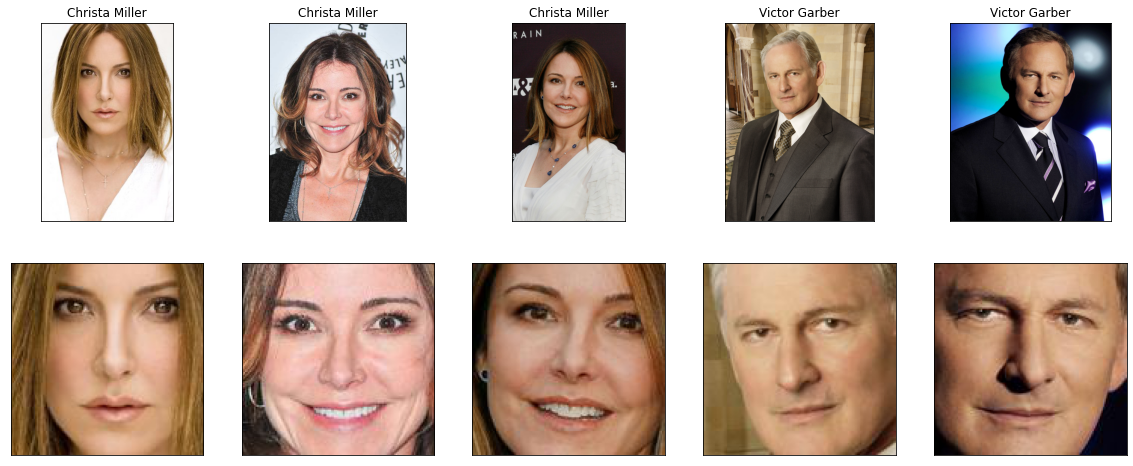

In [0]:
actresses_files_names_crop = os.listdir(folder_for_croped_actresses)
actors_files_names_crop = os.listdir(folder_for_croped_actors)
images = []
names = []

for i in range(20,23,1):
  img = io.imread(folder_for_actresses + "/" + actresses_files_names_crop[i])
  images.append(img)
  index_dot = actresses_files_names_crop[i].find('.')
  name = int(actresses_files_names_crop[i][:index_dot])
  id_metadata = np.where(np.array(metadata[:,0], dtype='int64') == name)[0][0]
  names.append(metadata[id_metadata,2])

for i in range(30,32,1):
  img = io.imread(folder_for_actors + "/" + actors_files_names_crop[i])
  images.append(img)
  index_dot = actors_files_names_crop[i].find('.')
  name = int(actors_files_names_crop[i][:index_dot])
  id_metadata = np.where(np.array(metadata[:,0], dtype='int64') == name)[0][0]
  names.append(metadata[id_metadata,2])

for i in range(20,23,1):
  img = io.imread(folder_for_croped_actresses + "/" + actresses_files_names_crop[i])
  images.append(img)
  index_dot = actresses_files_names_crop[i].find('.')
  name = int(actresses_files_names_crop[i][:index_dot])
  id_metadata = np.where(np.array(metadata[:,0], dtype='int64') == name)[0][0]
  names.append("")

for i in range(30,32,1):
  img = io.imread(folder_for_croped_actors + "/" + actors_files_names_crop[i])
  images.append(img)
  index_dot = actors_files_names_crop[i].find('.')
  name = int(actors_files_names_crop[i][:index_dot])
  id_metadata = np.where(np.array(metadata[:,0], dtype='int64') == name)[0][0]
  names.append("")

fix,axes = plt.subplots(2,5, figsize=(20,8), subplot_kw={'xticks':(),'yticks':()})
for name, image, ax in zip(names, images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(name)

# Neural network model

## Loss function

In [0]:
def triplet_loss(anchor, positive, negative):

  positive_distance = K.square(anchor - positive)
  negative_distance = K.square(anchor - negative)
  # distances - sqeuclidean
  positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
  negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
  loss = positive_distance - negative_distance
  # margin - maxplus
  loss = K.maximum(0.0, 1 + loss)

  return K.mean(loss)

## Accuracy function

In [0]:
def accuracy(anchor, positive, negative):

    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)

    return K.mean(positive_distance < negative_distance)

## Reading data for training

In [0]:
readed = np.load(folder_for_metadata +'/metadata.npz')
metadata = readed["metadata"]
x = metadata[:,0]
x = np.array(x, dtype='int64')
y = metadata[:,1]
y = np.array(y, dtype='int64')

## Functions for triples generation

In [0]:
def get_triples_indices(grouped, n):
    num_classes = len(grouped)
    list_labels = list(grouped.keys())
    pairs = []
    for i in range(0,n,1):
        pairs.append(np.random.choice(list_labels, size=2, replace = False))
    pairs = np.array(pairs)
    positive_labels = pairs[:,0]
    negative_labels = pairs[:,1]
    triples_indices = []
    for positive_label, negative_label in zip(positive_labels, negative_labels):
        negative = np.random.choice(grouped[negative_label])
        positive_group = grouped[positive_label]
        m = len(positive_group)
        anchor_j = np.random.randint(0, m)
        anchor = positive_group[anchor_j]
        positive_j = (np.random.randint(1, m) + anchor_j) % m
        positive = positive_group[positive_j]
        triples_indices.append([anchor, positive, negative])
    return np.asarray(triples_indices)

def get_triples_data(x, grouped, n):
    indices = get_triples_indices(grouped, n)
    x1,x2,x3 = [],[],[]
    for i in indices[:,0]:
      if x[i] < 55309:
        x1.append(io.imread(folder_for_croped_actors + "/" + str(x[i]) + ".jpg"))
      else:
        x1.append(io.imread(folder_for_croped_actresses + "/" + str(x[i]) + ".jpg"))
    for i in indices[:,1]:
      if x[i] < 55309:
        x2.append(io.imread(folder_for_croped_actors + "/" + str(x[i]) + ".jpg"))
      else:
        x2.append(io.imread(folder_for_croped_actresses + "/" + str(x[i]) + ".jpg"))
    for i in indices[:,2]:
      if x[i] < 55309:
        x3.append(io.imread(folder_for_croped_actors + "/" + str(x[i]) + ".jpg"))
      else:
        x3.append(io.imread(folder_for_croped_actresses + "/" + str(x[i]) + ".jpg"))
    x1 = np.array(x1)
    x2 = np.array(x2)
    x3 = np.array(x3)
    return x1, x2, x3
    
def triplet_generator(x, y, batch_size):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)
       
    while True:
        x_anchor, x_positive, x_negative = get_triples_data(x, grouped, batch_size)
        yield ({'anchor_input': x_anchor,
               'positive_input': x_positive,
               'negative_input': x_negative},
               None)

## Example triplet generation

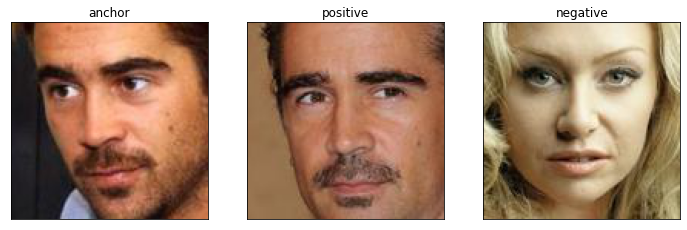

In [146]:
triplet = triplet_generator(x, y, 1)

array = []
for i in triplet:
  array.append(i)
  break

anchor = np.array(array[0][0]['anchor_input'])[0]
negative = np.array(array[0][0]['negative_input'])[0]
positive = np.array(array[0][0]['positive_input'])[0]

images = [anchor, positive, negative]
names = ["anchor", "positive", "negative"]
fix,axes = plt.subplots(1,3, figsize=(12,4), subplot_kw={'xticks':(),'yticks':()})
for name, image, ax in zip(names, images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(name)

## Embedding model

In [0]:
input_shape = (128, 128, 3)
base_input = Input(input_shape)
x1 = layers.Conv2D(32, (3, 3), activation='relu')(base_input)
x1 = layers.MaxPooling2D((2, 2))(x1)
x1 = layers.Conv2D(64, (3, 3), activation='relu')(x1)
x1 = layers.MaxPooling2D((2, 2))(x1)
x1 = layers.Dropout(0.25)(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(2, activation='linear')(x1)
embedding_model = Model(base_input, x1, name='embedding')

## Triplet model

In [0]:
anchor_input = Input(input_shape, name='anchor_input')
positive_input = Input(input_shape, name='positive_input')
negative_input = Input(input_shape, name='negative_input')
   
anchor_embedding = embedding_model(anchor_input)
positive_embedding = embedding_model(positive_input)
negative_embedding = embedding_model(negative_input)
 
inputs = [anchor_input, positive_input, negative_input]
outputs = [anchor_embedding, positive_embedding, negative_embedding]
triplet_model = Model(inputs, outputs)
triplet_model.add_loss(K.mean(triplet_loss(outputs[0], outputs[1], outputs[2])))
triplet_model.compile(loss=None, optimizer='adam', metrics={"custom_accuracy": accuracy})

In [31]:
batch_size = 30

history = triplet_model.fit_generator(triplet_generator(x, y, batch_size),
                                      steps_per_epoch=16,
                                      epochs=20,
                                      verbose=1)

Epoch 1/20
16/16 [==============================] - 34s 2s/step - loss: 1.0380
Epoch 2/20
16/16 [==============================] - 31s 2s/step - loss: 1.0040
Epoch 3/20
16/16 [==============================] - 31s 2s/step - loss: 1.0084
Epoch 4/20
16/16 [==============================] - 31s 2s/step - loss: 1.0017
Epoch 5/20
16/16 [==============================] - 31s 2s/step - loss: 0.9990
Epoch 6/20
16/16 [==============================] - 31s 2s/step - loss: 1.0085
Epoch 7/20
16/16 [==============================] - 31s 2s/step - loss: 1.0016
Epoch 8/20
16/16 [==============================] - 31s 2s/step - loss: 0.9993
Epoch 9/20
16/16 [==============================] - 31s 2s/step - loss: 0.9972
Epoch 10/20
16/16 [==============================] - 31s 2s/step - loss: 1.0148
Epoch 11/20
16/16 [==============================] - 31s 2s/step - loss: 0.9976
Epoch 12/20
16/16 [==============================] - 31s 2s/step - loss: 0.9986
Epoch 13/20
16/16 [==============================

In [0]:
triplet_model.save(folder_for_metadata + '/triplet.h5')

## Model loss

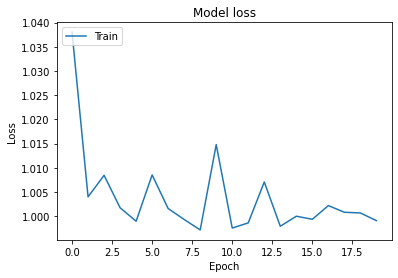

In [36]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')